In [1]:
# 2023

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen * j: self.slen * j + self.slen]) / float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [2]:
def timeseriesCVscore(x):
    errors = []
    values = data.values
    alpha, beta, gamma = x
    tscv = TimeSeriesSplit(n_splits=3)
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=24 * 7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [26]:
import sys
sys.path.insert(1, 'D:/kaneshi')
import kaneshi

from kaneshi.core.market_data import MarketData

m_config = {'symbol': 'XRPUSDT',
            'interval': 1,
            's_date': (2023, 1, 1),
            'e_date': (2024, 1, 1),
            'columns': 'Close',
            'price_type': 'Close',
           }

market = MarketData.from_config(**m_config)

data = market.raw_df['Close'][:10_000]

In [27]:
# x = [0, 0, 0]
# Минимизируем функцию потерь с ограничениями на параметры
# opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds=((0, 1), (0, 1), (0, 1)))
# alpha_final, beta_final, gamma_final = opt.x

In [28]:
alpha_final, beta_final, gamma_final = 0.0025230334804615673, 3.396778519054733e-05, 0.005431216853649945

In [29]:
model = HoltWinters(data[:-128], slen=24 * 7, alpha=alpha_final, beta=beta_final, gamma=gamma_final, n_preds=128,
                    scaling_factor=2.56)
model.triple_exponential_smoothing()

In [30]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN] * len(data))
    Anomalies[data.values < model.LowerBond] = data.values[data.values < model.LowerBond]

    plt.figure(figsize=(15, 5))
    plt.plot(model.result, label="Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color="grey")
    plt.plot(data.values, label="Actual")

    plt.plot(Anomalies, "o", markersize=10, label="Anomalies")
    plt.axvspan(len(data) - 128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)
    plt.show()

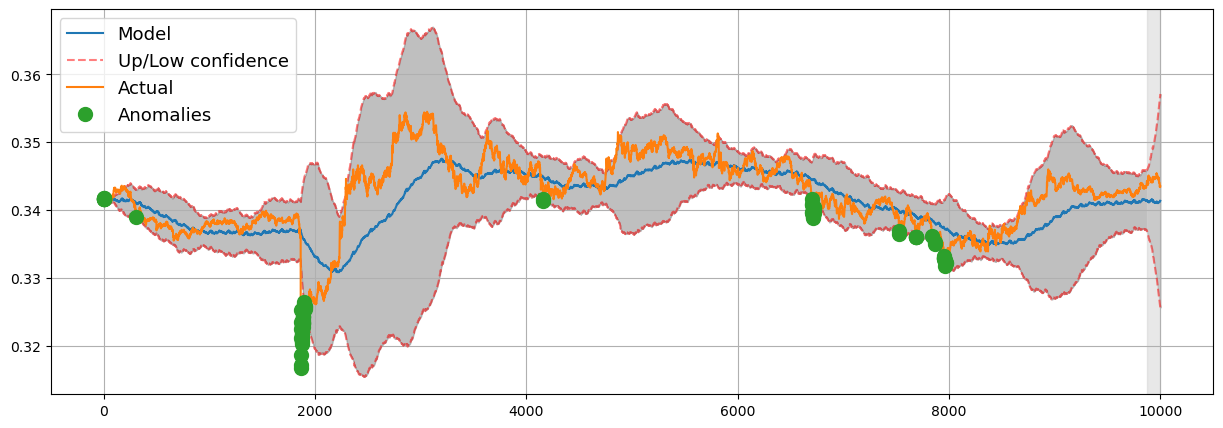

In [31]:
plotHoltWinters()